In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sys

if '/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages' not in sys.path:
    sys.path.append('/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages')
import torch
import snn_utils
from randman.randman import *
import matplotlib.pyplot as plt
import seaborn as sns
from randman_utils import *
from torch.utils.data import DataLoader, Dataset
from typing import Optional



In [2]:
from LIFlayer import OneHiddenModel,OneRecHiddenModel,NHiddenModel

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


In [ ]:
X_

In [82]:
spike_raster,labels = make_spike_raster_dataset()

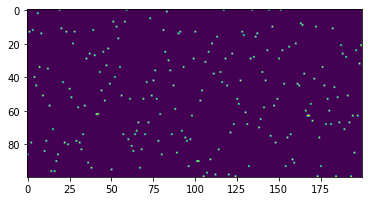

In [88]:
plt.imshow(spike_raster[0])

In [4]:
class RandmanDataset(Dataset):
    """Characterizes a PyTorch dataset for use with the PyTorch dataloader."""
    def __init__(self, data, labels):
        """Simple initialization of the given dataset."""
        self.data = data
        self.labels = labels

    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.labels)

    def __getitem__(self, index):
        """Retrives a single sample from the given dataset."""
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

def convert_spike_times_to_raster(spike_times: np.ndarray, timestep: float = 1.0, max_time: Optional[float] = None, num_neurons: Optional[int] = None, dtype=None):
    """
    Convert spike times array to spike raster array. 
    For now, all neurons need to have same number of spike times.
    
    Args:
        spike_times: MoreArrays, spiketimes as array of shape (batch_dim x spikes/neuron X 2)
            with final dim: (times, neuron_id)
    """

    if dtype is None:
        dtype = np.int16
    # spike_times = spike_times.astype(np.uint16)
    if num_neurons is None:
        num_neurons = int(np.nanmax(spike_times[:,:,1]))+1
    if max_time is None:
        max_time = np.nanmax(spike_times[:,:,0])
    num_bins = int(max_time / timestep + 1)

    spike_raster = np.zeros((spike_times.shape[0], num_bins, num_neurons), dtype=np.float32)
    batch_id = np.arange(spike_times.shape[0]).repeat(spike_times.shape[1])
    spike_times_flat = (spike_times[:, :, 0].flatten() / timestep).astype(dtype)
    neuron_ids = spike_times[:, :, 1].flatten().astype(dtype)
    np.add.at(spike_raster, (batch_id, spike_times_flat, neuron_ids), 1)
    return spike_raster


def make_spike_raster_dataset(nb_classes=10, nb_units=100, nb_steps=100, dim_manifold=2, nb_samples=1000, alpha=2.0, shuffle=True, seed=None):
# def make_spike_raster_dataset(nb_classes, nb_units, nb_steps, dim_manifold=2, nb_spikes=1, nb_samples=1000, alpha=2.0, shuffle=True):
# def make_spike_raster_dataset():
    spike_times,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=nb_units, nb_steps=nb_steps, dim_manifold=dim_manifold, seed=seed,nb_samples=nb_samples,shuffle=shuffle,alpha=alpha)
    spike_raster = convert_spike_times_to_raster(spike_times)
    return spike_raster, labels

def get_data_loaders(nb_classes, nb_units, nb_steps, nb_samples, batchsize):
    data, labels = make_spike_raster_dataset(nb_classes=nb_classes, nb_units=nb_units, nb_steps=nb_steps, nb_samples=nb_samples)

    NUM_SAMPLES_TOTAL = (nb_classes*nb_samples)
    NUM_SAMPLES_TRAIN = int(NUM_SAMPLES_TOTAL*0.8)

    data_train, labels_train = data[:NUM_SAMPLES_TRAIN], labels[:NUM_SAMPLES_TRAIN]
    data_test,  labels_test  = data[NUM_SAMPLES_TRAIN:], labels[NUM_SAMPLES_TRAIN:]

    dataset_train = RandmanDataset(data_train, labels_train)
    dataset_test = RandmanDataset(data_test, labels_test)

    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True, drop_last=True)
    dataloader_test = DataLoader(dataset_test, batch_size=batchsize, shuffle=True, drop_last=True)
    return dataloader_train, dataloader_test

In [11]:
data,labels = make_spike_raster_dataset()

In [15]:
data.shape

(10000, 100, 100)

In [5]:
dataloader_train, dataloader_test = get_data_loaders(4,200,100,1000,50)

In [21]:
dataloader_train?

Type:        DataLoader
String form: <torch.utils.data.dataloader.DataLoader object at 0x7fddd0776d00>
Length:      64
File:        ~/msc_thesis/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py
Docstring:  
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
loading order and optional automatic batching (collation) and memory pinning.

See :py:mod:`torch.utils.data` documentation page for more details.

Args:
    dataset (Dataset): dataset from which to load the data.
    batch_size (int, optional): how many samples per batch to load
        (default: ``1``).
    shuffle (bool, optional): set to ``True`` to have the data reshuffled
        at every epoch (default: ``False``).
    sampler (Sampler or Iterable, optional): defines the strategy to draw
        samples from the dataset. C

In [48]:
def train_test(data,test_frac=.2):
    train = data[:int(len(data)*(1-test_frac))]
    test = data[int(len(data)*(1-test_frac)):]
    return train,test

def get_X_y(data,labels,T):
    X_train, X_test = train_test(data)
    y_train, y_test = train_test(labels)
    X_train = prep_data(X_train,T=T)
    X_test = prep_data(X_test, T=T)
    y_train = prep_labels(y_train)
    y_test = prep_labels(y_test)
    return X_train, X_test, y_train,y_test

def create_data(N,T,batch_size,nb_classes,nb_samples,alpha,device='cpu'):
    data,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=N, nb_steps=T, dim_manifold=1, seed=42,nb_samples=nb_samples,shuffle=True,alpha=alpha)
    show_samples(data,labels)
    data = torch.IntTensor(data)
    X_train, X_test, y_train, y_test = get_X_y(data,labels,T)
    train_batch_ids = get_batches(X_train,batch_size)
    test_batch_ids = get_batches(X_test,batch_size)
    y_train = y_train.long()
    y_test = y_test.long()
    return torch.tensor(X_train,device=device),torch.tensor(X_test,device=device),torch.tensor(y_train,device=device),torch.tensor(y_test,device=device),torch.tensor(train_batch_ids,device=device),torch.tensor(test_batch_ids,device=device)

In [25]:
def get_Ws(N,nb_classes,epsilon=.5,base_w = 1,w = 1,plot=True,device=device):
    n_assemblies = nb_classes
    ss = StandardScaler()
    mask, cluster_ids, _ = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=1./n_assemblies, modularity=1.)
    mask = (mask* (base_w*w)) + base_w

    W, cluster_ids, t = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=epsilon, modularity=0.)
    if w > 0.:
        W *= base_w
        W *= mask

    if epsilon ==1:
        W = W-1
    W2 = (W != 0).astype(int)
    if plot:
        plt.title('W')
        plt.imshow(W)
        plt.colorbar()
        plt.show()
        plt.title('W2')
        plt.imshow(W2)
        plt.colorbar()
        plt.show()
    return torch.tensor(W,device=device,dtype=torch.float32), torch.tensor(W2,device=device,dtype=torch.float32)

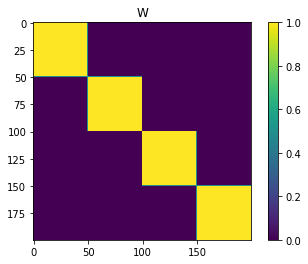

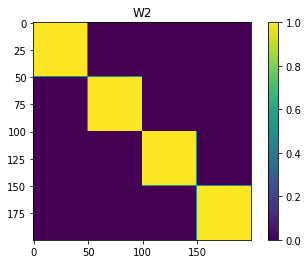

In [27]:
W,W2 = get_Ws(200,4,1)

In [9]:
def validation_acc(X_test,y_test,model,test_batch_ids):
    sum_acc = 0
    decay=.99
    count = 0
    for i in range(len(test_batch_ids)):
        model.eval()
        model.init_states()
        Sprobe = torch.zeros((batch_size,model.out_channels),device=device)
        #out = torch.zeros((batch_size,model.out_channels),device=device)
        #out_rec = [out]
        count +=1
        for n in range(T):

            out_state = model(X_test[test_batch_ids[i],n])
            #out_rec.append(out_state.U)
            Sprobe = decay * Sprobe + out_state.S

        #out_rec = torch.stack(out_rec,dim=1)
        #prediction = torch.max(out_rec,1).values
        prediction = Sprobe
        accuracy = acc_from_pred(prediction,y_test[test_batch_ids[i]])
        sum_acc = sum_acc + accuracy
    avg_acc = sum_acc/count
    return avg_acc,prediction,y_test[test_batch_ids[i]]

def acc_from_pred(prediction,y):

    return (y == prediction.argmax(axis=1)).sum()/len(prediction)

In [37]:
#def train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W,W2,lr,decay,epochs=100,use_W=False,use_W2=False,print_each=5,device='cpu'):
def train(T,dataloader_train,nb_classes,model,W,W2,lr,decay=.99,epochs=100,use_W=False,use_W2=False,print_each=5,device=device):
    #in_channels=N
    #hidden_channels = N
    #out_channels = nb_classes
    #model = FiveHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

    #mse_loss = torch.nn.MSELoss()
    ce_loss = torch.nn.CrossEntropyLoss()

    #apply W
    if use_W:
        model.init_mod_weights(W)

    #layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))
    params = model.parameters()
    opt = torch.optim.Adam(params, lr=lr, betas=[0., .95]) #lr is the learning rate
    loss_hist = []
    acc_hist = []
    #epochs
    for e in range(epochs):
        batch_loss = 0
        batch_acc=0
        model.train()

        #batches

        #if e%10 == 0:
        #    y = model.layer1.fc_layer.weight.clone().detach()
        #    plt.imshow(y)
        #    plt.show()
        #plt.imshow(W)
        #plt.show()
        count = 0
        for x,label in dataloader_train:
            model.init_states()
            Sprobe = torch.zeros((dataloader_train.batch_size,model.out_channels),device=device)
            x = x.to(device)
            label=label.to(device)
            for n in range(T):
                out_state = model(x[:,n])

                Sprobe = decay * Sprobe + out_state.S
            prediction = Sprobe
            accuracy = acc_from_pred(prediction,label)
            loss = ce_loss(prediction,label)
            loss.backward()
            opt.step()
            opt.zero_grad()

#        for i in range(len(train_batch_ids)):
#        
#
#            model.init_states()
#            Sprobe = torch.zeros((batch_size,model.out_channels),device=device)
#            #out = torch.zeros((batch_size,model.out_channels),device=device)
#            #out_rec = [out]
#        #timesteps
#            for n in range(T):
#                out_state = model(X_train[train_batch_ids[i],n])
#
#            #add decay for leakiness
#            #collect spikes over time
#                Sprobe = decay * Sprobe + out_state.S
#                #out_rec.append(out_state.U)
#
#            #out_rec = torch.stack(out_rec,dim=1)
#            #prediction = torch.max(out_rec,1).values
#            prediction = Sprobe
#            accuracy = acc_from_pred(prediction,y_train[train_batch_ids[i]])
#            loss = ce_loss(prediction,y_train[train_batch_ids[i]])
#
#            loss.backward()
#            opt.step()
#            opt.zero_grad()
            if use_W2:
                model.init_mod_weights(W2)
            count+=1
            batch_acc = batch_acc + accuracy
            batch_loss = batch_loss + loss
        #epoch_acc = batch_acc/(len(train_batch_ids))
        epoch_acc = batch_acc/count
        epoch_loss = batch_loss/count
        #epoch_loss = batch_loss/(len(train_batch_ids))
        loss_hist = loss_hist + [float(epoch_loss)]
        acc_hist = acc_hist + [float(epoch_acc)]


        if e%print_each==0:
            print(f'epoch {e}: \n loss: {epoch_loss}')
            print(f'train_acc: {epoch_acc}')
    return loss_hist,acc_hist

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


NameError: name 'out_state' is not defined

In [36]:
dataloader_train.batch_size

50

created 16 batches
created 4 batches


/tmp/ipykernel_2161447/4236364291.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X_train,device=device),torch.tensor(X_test,device=device),torch.tensor(y_train,device=device),torch.tensor(y_test,device=device),torch.tensor(train_batch_ids,device=device),torch.tensor(test_batch_ids,device=device)


TypeError: __init__() got an unexpected keyword argument 'batch_size'

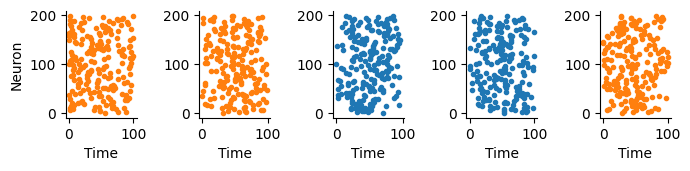

In [49]:
N=200
T=100
batch_size=100
nb_classes=2
#W,W2 = get_Ws(N=N,nb_classes=nb_classes,epsilon=1,device=device)

X_train,X_test,y_train, y_test, train_batch_ids,test_batch_ids =create_data(N=N,T=T,batch_size=batch_size,nb_classes=nb_classes,nb_samples=1000,alpha=1.5,device=device)
model = OneRecHiddenModel(in_channels=N,hidden_channels=N,out_channels=nb_classes,batch_size=batch_size,device=device)

AttributeError: 'DataLoader' object has no attribute 'device'

In [34]:
from LIFlayer import NHiddenModel

model = NHiddenModel(num_hidden_layers=1,in_channels=200,hidden_channels=200,out_channels=4).to(device)

In [36]:
W.device

device(type='cuda', index=0)

In [38]:
loss, acc = train(T=100,dataloader_train=dataloader_train,nb_classes=4,model=model,use_W=True,use_W2=True,lr=1e-4,decay=.99,W=W,W2=W2,print_each=1,device=device)

epoch 0: 
 loss: 1.4267343282699585
train_acc: 0.25218749046325684
epoch 1: 
 loss: 1.3956773281097412
train_acc: 0.2634374797344208
epoch 2: 
 loss: 1.3896615505218506
train_acc: 0.2540624737739563
epoch 3: 
 loss: 1.3771122694015503
train_acc: 0.28593751788139343
epoch 4: 
 loss: 1.3054797649383545
train_acc: 0.3965623676776886
epoch 5: 
 loss: 1.1721967458724976
train_acc: 0.56968754529953
epoch 6: 
 loss: 1.0190174579620361
train_acc: 0.70250004529953
epoch 7: 
 loss: 0.8414143919944763
train_acc: 0.8134373426437378
epoch 8: 
 loss: 0.6223592162132263
train_acc: 0.8943747878074646
epoch 9: 
 loss: 0.522743821144104
train_acc: 0.9053124189376831
epoch 10: 
 loss: 0.353916198015213
train_acc: 0.9312499165534973
epoch 11: 
 loss: 0.4170617461204529
train_acc: 0.875312328338623
epoch 12: 
 loss: 0.3798607289791107
train_acc: 0.86781245470047
epoch 13: 
 loss: 0.6435477137565613
train_acc: 0.7699999809265137
epoch 14: 
 loss: 0.48099517822265625
train_acc: 0.8006250262260437
epoch 15: 


In [ ]:
model.

In [55]:
loss, acc = train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W=W,W2=W2,lr=1e-4,decay=.99,use_W=True,use_W2=True,print_each=5,epochs=100,device=device)

epoch 0: 
 loss: 1.7269775867462158
train_acc: 0.5487499833106995
epoch 5: 
 loss: 0.6981631517410278
train_acc: 0.5843749642372131
epoch 10: 
 loss: 0.6150588393211365
train_acc: 0.6674998998641968
epoch 15: 
 loss: 0.5602189898490906
train_acc: 0.6899999380111694
epoch 20: 
 loss: 0.38960620760917664
train_acc: 0.8512499332427979
epoch 25: 
 loss: 0.26687148213386536
train_acc: 0.9118749499320984
epoch 30: 
 loss: 0.17547133564949036
train_acc: 0.93812495470047
epoch 35: 
 loss: 0.0912538468837738
train_acc: 0.9706249237060547
epoch 40: 
 loss: 0.3988977074623108
train_acc: 0.9099999070167542
epoch 45: 
 loss: 0.6095557808876038
train_acc: 0.8943749666213989
epoch 50: 
 loss: 0.021608566865324974
train_acc: 0.9975000023841858
epoch 55: 
 loss: 0.012993112206459045
train_acc: 0.9993749856948853
epoch 60: 
 loss: 0.4422604739665985
train_acc: 0.9368749260902405
epoch 65: 
 loss: 0.003700142726302147
train_acc: 1.0
epoch 70: 
 loss: 0.017636405304074287
train_acc: 1.0
epoch 75: 
 loss: 

In [11]:
model.layer2.fc_layer.weight.data.device

device(type='cuda', index=0)

In [58]:
val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
#val_acc_hist = val_acc_hist + [val_acc]
print(f'val_acc: {val_acc}')

val_acc: 1.0


torch.Size([800, 100, 100])

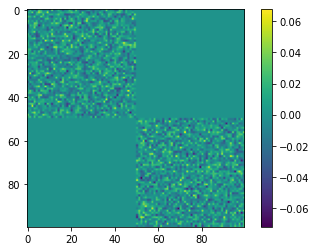

In [64]:
plt.imshow(model.layer2.fc_layer.weight.data.cpu())
plt.colorbar()

In [15]:
data1, data2 = get_data_loaders(4,200,100,1000,50)

In [17]:
data1.


50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
